In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
wine_quality = fetch_ucirepo(id = 186)
x = wine_quality.data.features
y = wine_quality.data.targets
#print(wine_quality.metadata)
#print(wine_quality.variables)

Frequency distribution of wine quality scores:

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


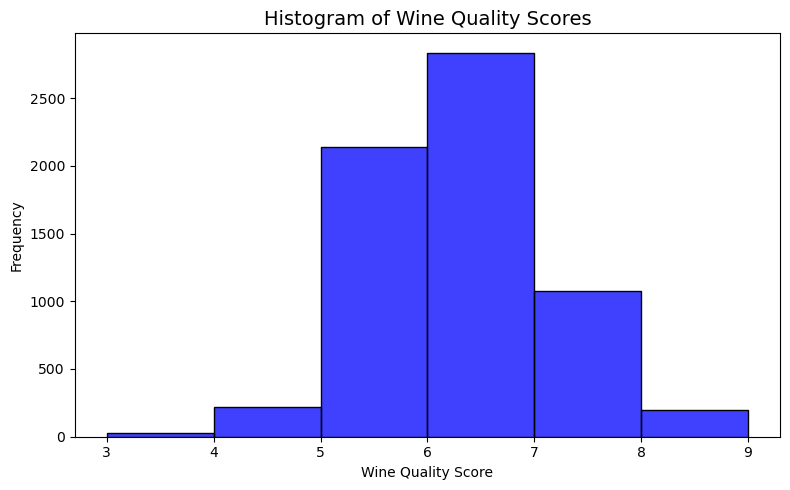

In [5]:
df = pd.concat([x, y], axis=1)
quality_counts = df['quality'].value_counts().sort_index()
print("Frequency distribution of wine quality scores:\n")
print(quality_counts)
plt.figure(figsize=(8, 5))
sns.histplot(df['quality'], bins=range(3, 10), kde=False, color="blue", edgecolor='black')
plt.title("Histogram of Wine Quality Scores", fontsize=14)
plt.xlabel("Wine Quality Score")
plt.ylabel("Frequency")
plt.xticks(range(3, 10))
plt.tight_layout()
plt.show()

In [7]:
def classify_quality(q):
    if q <6 :
        return "bad"
    elif q == 6:
        return "average"
    else:
        return "good"

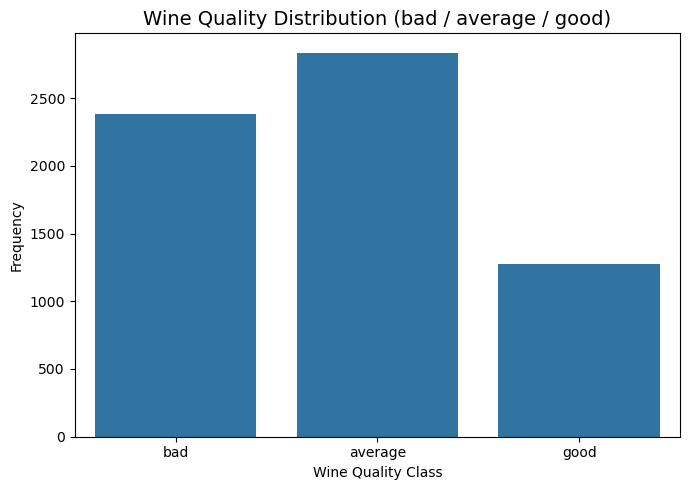

In [9]:
df["label"] = df["quality"].apply(classify_quality)
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="label", order=["bad", "average", "good"])
plt.title("Wine Quality Distribution (bad / average / good)", fontsize=14)
plt.xlabel("Wine Quality Class")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [11]:
df["label"] = df["label"].astype("category")
df.drop("quality", axis=1, inplace=True)

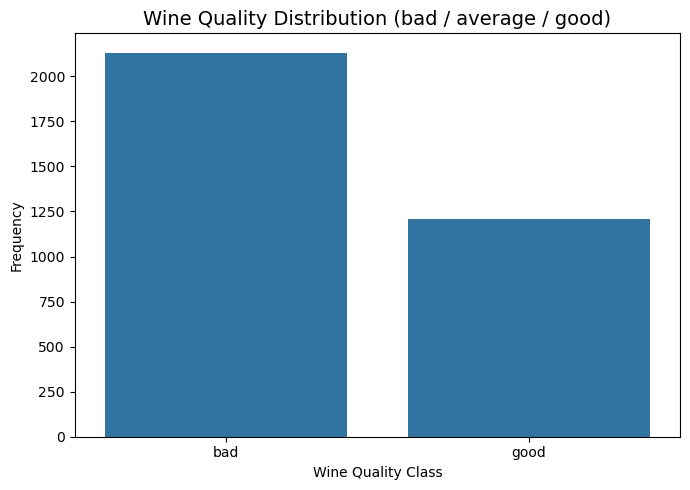

In [13]:
# applying SQC to remove outliers
df_original = df.copy()

for col in df.select_dtypes(include=np.number).columns:
    m = df[col].mean()
    s = df[col].std()
    df = df[(df[col] >= m - 3*s) & (df[col] <= m + 3*s)]
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="label", order=["bad", "good"])
plt.title("Wine Quality Distribution (bad / average / good)", fontsize=14)
plt.xlabel("Wine Quality Class")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

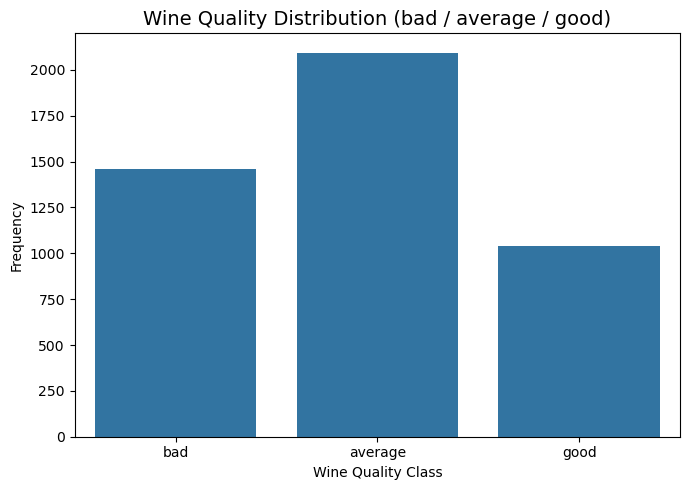

In [13]:
df_original = df.copy()

for col in df.select_dtypes(include=np.number):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="label", order=["bad","average", "good"])
plt.title("Wine Quality Distribution (bad / average / good)", fontsize=14)
plt.xlabel("Wine Quality Class")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [15]:
original_counts = df_original["label"].value_counts()
cleaned_counts = df["label"].value_counts()
total_removed = len(df_original) - len(df)
removed_per_class = original_counts - cleaned_counts
print(f" Total data points before outlier removal: {len(df_original)}")
print(f" Total data points after outlier removal:  {len(df)}")
print(f" Total data points removed: {total_removed}\n")
print(" Number of points removed per class:")
print(removed_per_class.fillna(0).astype(int))
print("\n Remaining points per class after outlier removal:")
print(cleaned_counts)

 Total data points before outlier removal: 6497
 Total data points after outlier removal:  5939
 Total data points removed: 558

 Number of points removed per class:
label
average    236
bad        252
good        70
Name: count, dtype: int32

 Remaining points per class after outlier removal:
label
average    2600
bad        2132
good       1207
Name: count, dtype: int64


In [17]:
x= df.drop(columns="label")
y = df["label"]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

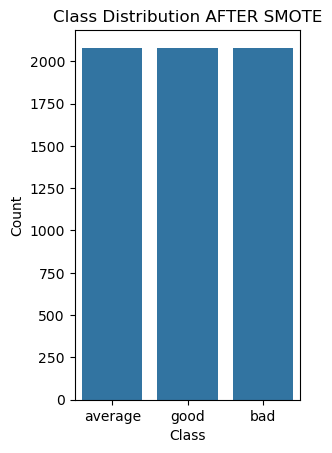

In [21]:
from collections import Counter
plt.subplot(1, 2, 2)
sns.barplot(x=list(Counter(y_train).keys()), y=list(Counter(y_train).values()))
plt.title("Class Distribution AFTER SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [23]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)

C:\Users\HP\AppData\Local\Temp\ipykernel_17024\1156216382.py:5: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


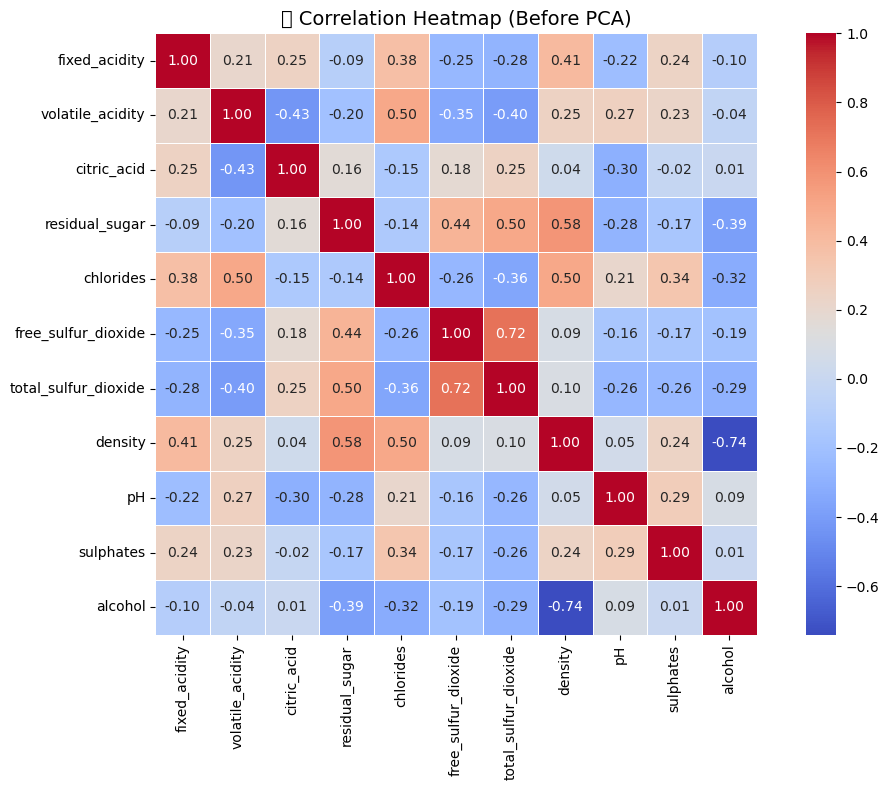

In [25]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(11, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("🔍 Correlation Heatmap (Before PCA)", fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
# scaling the features before applying pca
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

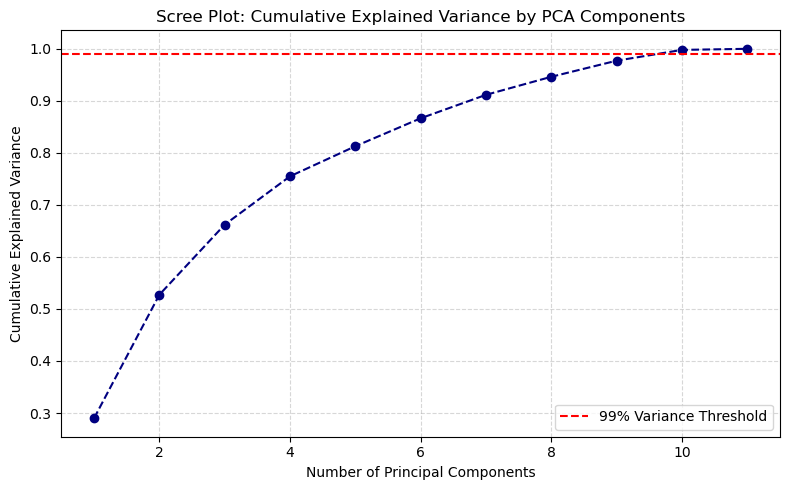

 Number of components to retain ≥99% variance: 10


In [29]:
#to find the number of components to be retained in PCA
pca = PCA()
pca.fit(x_train_scaled)
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var)+1), cumulative_var, marker='o', linestyle='--', color='navy')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Variance Threshold')
plt.title("Scree Plot: Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
n_components_95 = np.argmax(cumulative_var >= 0.99) + 1
print(f" Number of components to retain ≥99% variance: {n_components_95}")

In [31]:
#applying PCA
pca = PCA(n_components=10)
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)

In [33]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [100], "max_depth": [5, 10, None]}),
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7]}),
    "Naive Bayes": (GaussianNB(), {}),
    "SVM": (SVC(probability=True), {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"]}),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0),
        {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.7, 0.9, 1.0],
            "colsample_bytree": [0.7, 0.9, 1.0]
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(),
        {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    )
}

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
results = []
predictions = {}
probabilities = {}

for name, (model, params) in models.items():
    print(f"\nTraining {name} with RandomizedSearchCV...")
    if params:
        search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    else:
        search = model
    if isinstance(search, RandomizedSearchCV):
        search.fit(x_train_scaled, y_train_enc)
        best_model = search.best_estimator_
    else:
        search.fit(x_train_scaled, y_train_enc)
        best_model = search
    y_pred_enc = best_model.predict(x_val_scaled)
    y_prob = best_model.predict_proba(x_val_scaled)
    y_pred = label_encoder.inverse_transform(y_pred_enc)

    acc = accuracy_score(y_val, y_pred)
    macro_precision = precision_score(y_val, y_pred, average='macro')
    macro_recall = recall_score(y_val, y_pred, average='macro')
    macro_f1 = f1_score(y_val, y_pred, average='macro')

    results.append((name, round(acc, 4), round(macro_precision, 4), round(macro_recall, 4), round(macro_f1, 4)))
    predictions[name] = y_pred
    probabilities[name] = y_prob



Training Logistic Regression with RandomizedSearchCV...

Training Random Forest with RandomizedSearchCV...


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Training KNN with RandomizedSearchCV...


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Training Naive Bayes with RandomizedSearchCV...

Training SVM with RandomizedSearchCV...


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Training XGBoost with RandomizedSearchCV...

Training AdaBoost with RandomizedSearchCV...


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [37]:
print("SQC + PCA + Smote")
result_df2 = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro Precision", "Macro Recall", "Macro F1-score"])
print("\nModel Evaluation Metrics:\n", result_df2)
sorted_results2 = result_df2.sort_values(by="Macro F1-score", ascending=False).reset_index(drop=True)
print("\nBest Models Sorted by Macro F1-score:")
print(sorted_results2.head())

best_model_name2 = sorted_results2.loc[0, "Model"]
print(f"\n✅ Best Model Based on Macro F1-score: {best_model_name2}")

SQC + PCA + Smote

Model Evaluation Metrics:
                  Model  Accuracy  Macro Precision  Macro Recall  \
0  Logistic Regression    0.5539           0.5479        0.5930   
1        Random Forest    0.7071           0.6990        0.7203   
2                  KNN    0.6086           0.6040        0.6302   
3          Naive Bayes    0.4874           0.4944        0.5539   
4                  SVM    0.6145           0.6077        0.6443   
5              XGBoost    0.7088           0.7057        0.7132   
6             AdaBoost    0.5901           0.5830        0.6214   

   Macro F1-score  
0          0.5499  
1          0.7068  
2          0.6127  
3          0.4670  
4          0.6162  
5          0.7091  
6          0.5897  

Best Models Sorted by Macro F1-score:
           Model  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0        XGBoost    0.7088           0.7057        0.7132          0.7091
1  Random Forest    0.7071           0.6990        0.7203          0.7

In [41]:
def plot_conf_matrix(y_true, y_pred, title):
    labels = ["bad", "average", "good"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

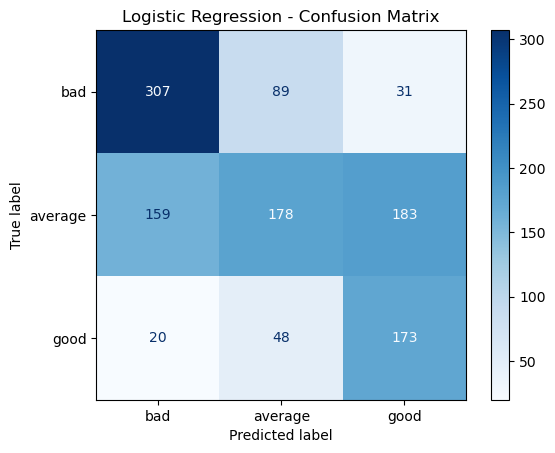

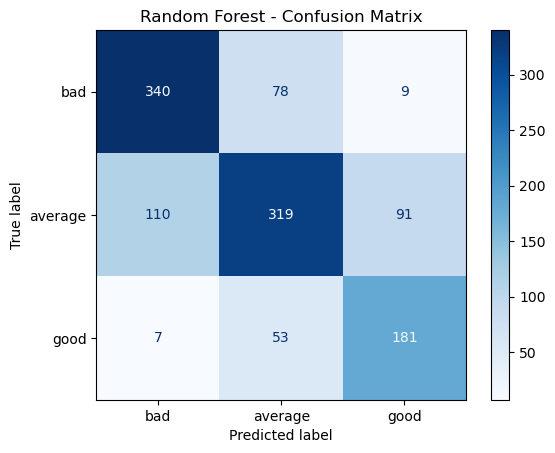

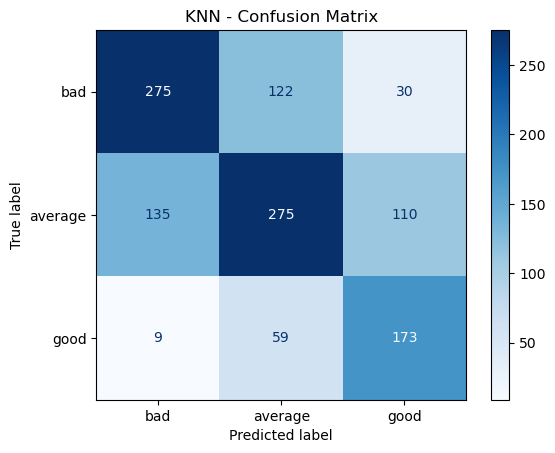

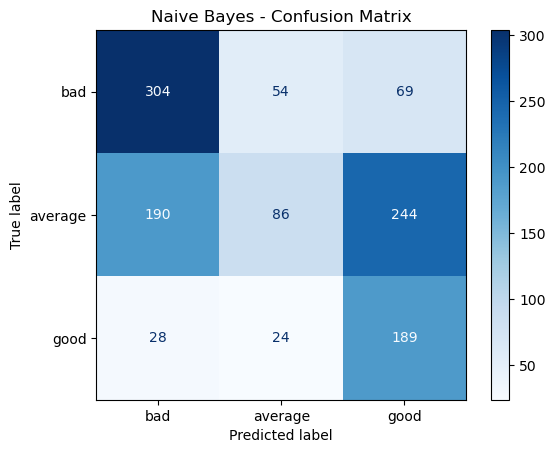

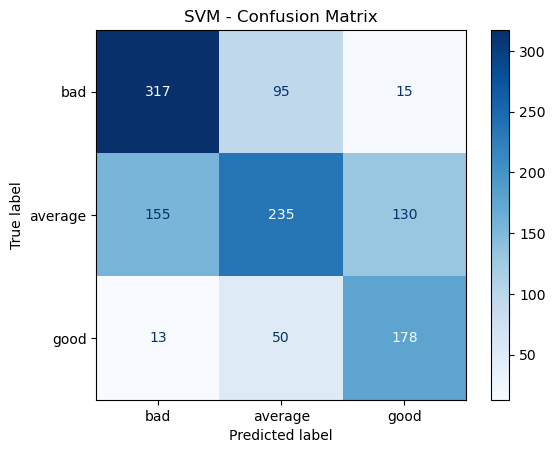

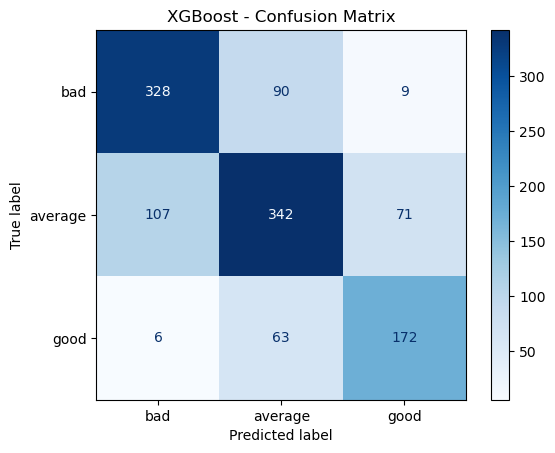

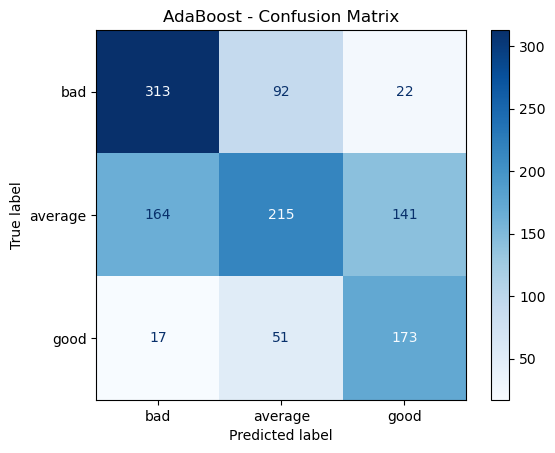

In [43]:
for model_name, y_pred in predictions.items():
    plot_conf_matrix(y_val, y_pred, f"{model_name} - Confusion Matrix")

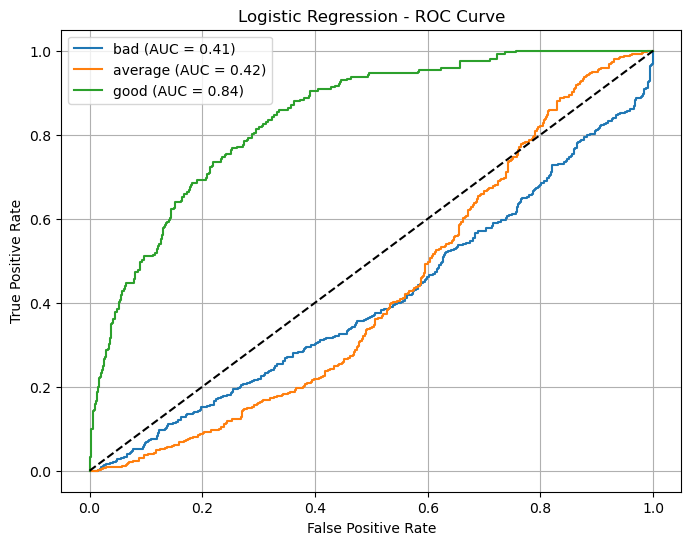

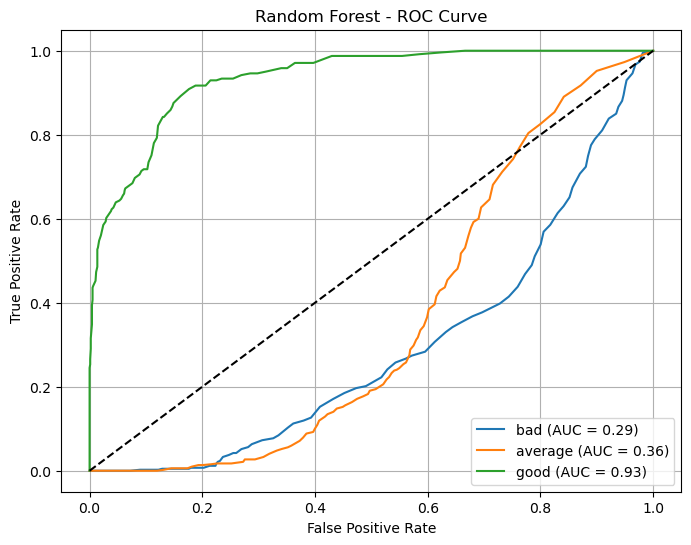

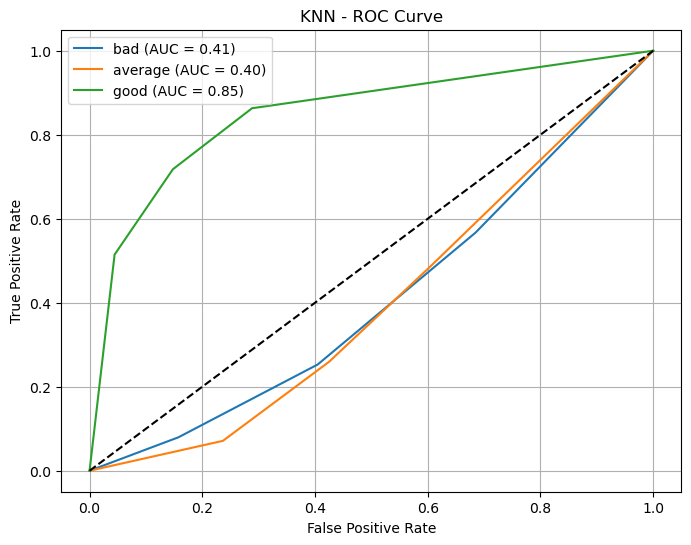

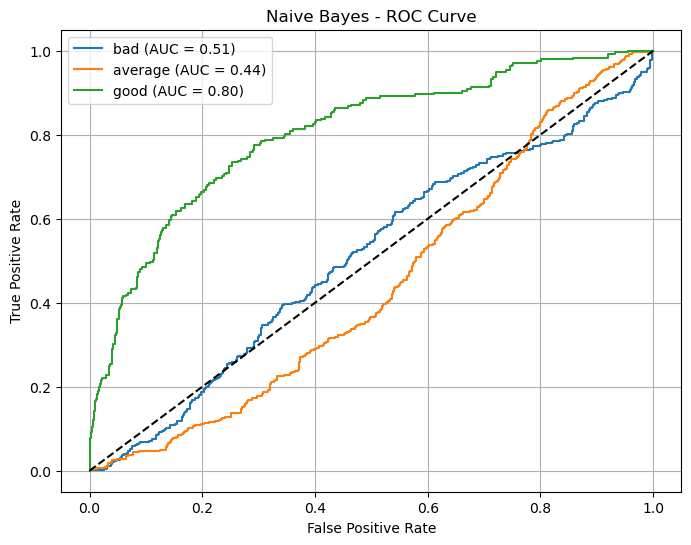

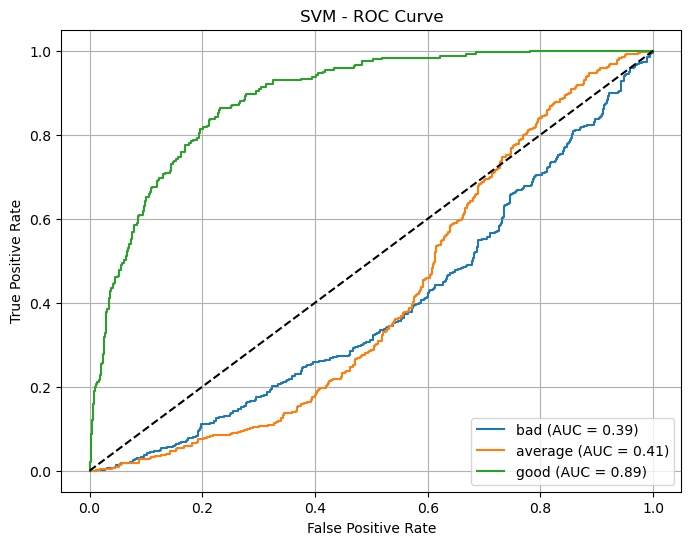

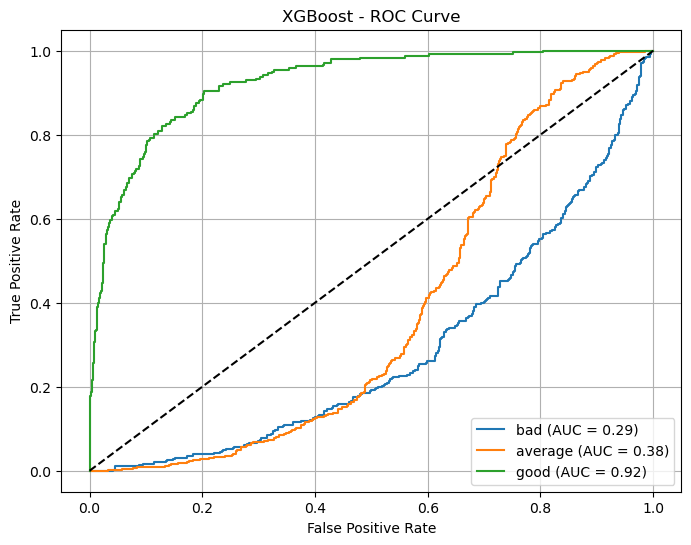

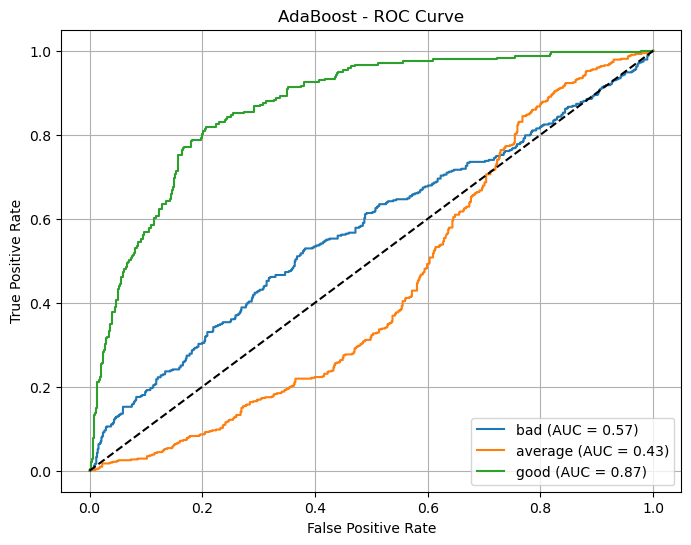

In [45]:
labels = ["bad", "average", "good"]
y_val_bin = label_binarize(y_val, classes=labels)
for model_name, probs in probabilities.items():
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()